In [441]:
import os
import json
import numpy as np
from helpers import *

In [384]:
# refine keypoints
def ssd(a, b):
    return np.sum(np.subtract(a, b)**2)

def ncc(a, b):
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    return np.dot(a.flatten(), b.flatten()) / (norma * normb)
 
def get_window(im, point, h_size):
    x, y = int(point[0]), int(point[1])  
    window = im[y - h_size:y + h_size, x - h_size:x + h_size]
    return window

def refine_point(k1, k2, half_search_size=3, half_window_size=5):
    max_metric = 0
    best_k2 = k2
    try:
        for offset_x in range(-half_search_size, half_search_size):
            for offset_y in range(-half_search_size, half_search_size):
                refined_k2 = [k2[0] + offset_x, k2[1] + offset_y]
                w1 = get_window(im1, k1, half_window_size)
                w2 = get_window(im2, refined_k2, half_window_size)
                metric = ssd(w1, w2)
                if metric > max_metric:
                    max_metric = metric
                    best_k2 = refined_k2
    except:
        return k2
    
    return best_k2

def refine_points(key1, key2, half_search_size=3, half_window_size=5):
    new_k2s = []
    for k1, k2 in zip(key1, key2):
        new_k2s += [refine_point(k1, k2, half_search_size=half_search_size, half_window_size=half_window_size)]
    return new_k2s

In [385]:
def computeH(pts1, pts2):    
    A = []
    b = np.zeros(len(pts1)*2 + 1)
    for p1, p2 in zip(pts1, pts2):
        x, y = p1[0], p1[1]
        wx, wy = p2[0], p2[1]
        A.append(np.array([-x, -y, -1, 0, 0, 0, x * wx, y * wx, wx]))
        A.append(np.array([0, 0, 0, -x, -y, -1, x * wy, y * wy, wy]))
    
    A.append(np.array([0, 0, 0, 0, 0, 0, 0, 0, 1]))
    b[-1] = 1
    
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)

    h = np.linalg.lstsq(A, b, rcond=None)
    h = h[0]    
    h = h / h[8]
    return h.reshape((3, 3))

def warpImages(im1, H):
    # H == im1 coords -> im2 coords
    x = np.repeat((np.arange(0, im1.shape[1]))[None, ...], im1.shape[0], axis=0)
    y = np.repeat(np.arange(0, im1.shape[0])[..., None], im1.shape[1], axis=1)
    coords = np.stack([x, y, np.ones(x.shape)])

    for i in range(coords.shape[2]):
        coords[:, :, i] = H @ coords[:, :, i]
    
    coords = coords / coords[2]
    coords = coords.astype(int)
    coords[0] = np.clip(coords[0], 0, im1.shape[1] - 1)
    coords[1] = np.clip(coords[1], 0, im1.shape[0] - 1)
    warped_img = im1[coords[1], coords[0], :]
    
    # add alpha channel that is clear on clipped coordinates
    bad_coord_mask = np.multiply(coords[0], coords[1])
    bad_coord_mask[coords[0] == im1.shape[1] - 1] = 0
    bad_coord_mask[coords[1] == im1.shape[0] - 1] = 0
    bad_coord_mask[bad_coord_mask > 0] = 1
    return warped_img, bad_coord_mask

def get_alpha_blend(shape, horizontal=True, left_top=True):
    if horizontal:
        alpha_blend = np.ones(shape)
    else:
        alpha_blend = np.ones(shape).T
    
    if left_top:
        alpha_blend[:, :] = np.linspace(1, 0, alpha_blend.shape[1])
    else:
        alpha_blend[:, :] = np.linspace(0, 1, alpha_blend.shape[1])
    
    if not horizontal:
        return alpha_blend.T
    else:
        return alpha_blend


In [408]:
def get_extra_img(im1, H, H_inv, vertical=True):
    max_coords = H @ np.array([0, im1.shape[0], 1]) 
    max_coords = max_coords / max_coords[2]
    if vertical:
        max_y = int(max_coords[1])

        # create coordinates for im1 outside im2 view
        y = np.repeat(np.arange(im1.shape[0], max_y)[..., None], im1.shape[1], axis=1)
        x = np.repeat(np.arange(0, im1.shape[1])[None, ...], y.shape[0], axis=0)
        
        coords = np.stack([x, y, np.ones(x.shape)])
    else:
        min_x = int(max_coords[0])

        # create coordinates for im1 outside im2 view
        x = np.repeat(np.arange(min_x, 0)[None, ...], im1.shape[0], axis=0)
        y = np.repeat(np.arange(0, im1.shape[0])[..., None], x.shape[1], axis=1)
        coords = np.stack([x, y, np.ones(x.shape)])
        
    for i in range(coords.shape[2]):
        coords[:, :, i] = H_inv @ coords[:, :, i]

    coords = coords / coords[2]
    coords = coords.astype(int)
    coords[0] = np.clip(coords[0], 0, im1.shape[1] - 1)
    coords[1] = np.clip(coords[1], 0, im1.shape[0] - 1)
    extra_img = im1[coords[1], coords[0], :]

    # add alpha channel that is clear on clipped coordinates
    bad_coord_mask = np.multiply(coords[0], coords[1])
    bad_coord_mask[coords[0] == im1.shape[1] - 1] = 0
    bad_coord_mask[coords[1] == im1.shape[0] - 1] = 0
    bad_coord_mask[bad_coord_mask > 0] = 1
    return extra_img, bad_coord_mask

def morph_images_vertical(im1, im2, key1, key2, blend_level=3):
    # im1 is bottom, im2 is top
    # higher blend level -> greater delta in weights for im1 and im2

    H = computeH(key1, key2)
    H_inv = np.linalg.inv(H)
    warped_img, bad_coord_mask = warpImages(im1, H_inv)

    # blend overlapping regions
    warped_alpha = get_alpha_blend(warped_img.shape[:2], horizontal=False, left_top=False)
    warped_alpha = np.clip(bad_coord_mask * warped_alpha**blend_level, 0, 1)
    warped_alpha = np.repeat(warped_alpha[..., None], 3, axis=-1)

    # blend two images together
    blended_img = warped_alpha * warped_img + (1 - warped_alpha) * im2

    # find non overlapping region
    extra_img, _ = get_extra_img(im1, H, H_inv)
    
    # combine blended and extra image
    final_img = np.zeros((extra_img.shape[0] + blended_img.shape[0], max(extra_img.shape[1],  blended_img.shape[1]), 3))    
    final_img[:blended_img.shape[0], :blended_img.shape[1]] = blended_img
    final_img[blended_img.shape[0]:, :] = extra_img
    return final_img

def morph_images_horizontal(im1, im2, key1, key2, blend_level=3):
    # im1 is right, im2 is left??????????
    # higher blend level -> greater delta in weights for im1 and im2

    H = computeH(key1, key2)
    H_inv = np.linalg.inv(H)
    warped_img, bad_coord_mask = warpImages(im1, H_inv)

    # blend overlapping regions
    # TODO check this
    warped_alpha = get_alpha_blend(warped_img.shape[:2], horizontal=True, left_top=True)
    warped_alpha = np.clip(bad_coord_mask * warped_alpha**blend_level, 0, 1)
    warped_alpha = np.repeat(warped_alpha[..., None], 3, axis=-1)

    # blend two images together
    blended_img = warped_alpha * warped_img + (1 - warped_alpha) * im2

    # find non overlapping region
    extra_img, _ = get_extra_img(im1, H, H_inv, vertical=False)
    
    # combine blended and extra image
    final_img = np.zeros((max(extra_img.shape[0], blended_img.shape[0]), extra_img.shape[1] + blended_img.shape[1], 3))    
    final_img[:, :extra_img.shape[1]] = extra_img
    final_img[:, extra_img.shape[1]:] = blended_img

    return final_img


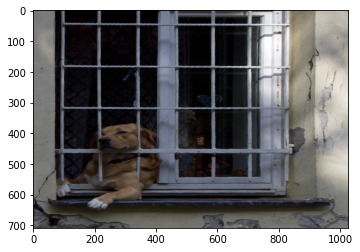

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


array([[[0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.47843137, 0.48235294, 0.47843137, 1.        ],
        ...,
        [0.71372549, 0.69019608, 0.64313725, 1.        ],
        [0.69803922, 0.6745098 , 0.62745098, 1.        ],
        [0.69803922, 0.6745098 , 0.62745098, 1.        ]],

       [[0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.47843137, 0.48235294, 0.47843137, 1.        ],
        ...,
        [0.70588235, 0.68235294, 0.63137255, 1.        ],
        [0.70588235, 0.68235294, 0.63529412, 1.        ],
        [0.70588235, 0.68235294, 0.63529412, 1.        ]],

       [[0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.48235294, 0.48627451, 0.48235294, 1.        ],
        [0.47843137, 0.48235294, 0.47843137, 1.        ],
        ...,
        [0.6627451 , 0.63921569, 0.58823529, 1.        ],
        [0.65098039, 0.627450

In [443]:
file_name = 'out/snake_dog.json'
im1 = 'in/snake.png'
im2 = 'in/dog.png'

im1 = read(im1)
im2 = read(im2)

# read keypoints 
with open(file_name, 'r') as f:
    all_points = json.load(f)

key1 = all_points['first']
key2 = all_points['second']

ref_key = [[400, 400], [400, 800], [1000, 400], [1000, 800]]

ref_key = np.array(ref_key) - [300, 350]
key1 = np.array(key1)

H = computeH(key2, ref_key)
H_inv = np.linalg.inv(H)
warped_img, _ = warpImages(im2, H_inv)
plt.imshow(warped_img)
plt.show()
save(warped_img, 'out/dog_warp.png')

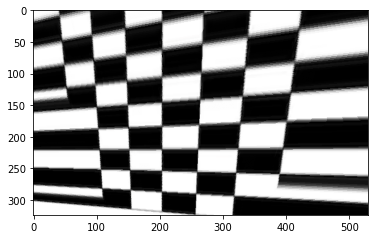

In [440]:
file_name = 'out/checkerboard_paintings.json'
im1 = 'in/checkerboard.png'
im1 = read(im1)

# read keypoints 
with open(file_name, 'r') as f:
    all_points = json.load(f)

key1 = all_points['first']
key1 = np.array(key1)

ref_key = [[150, 150], [150, 250], [200, 250], [200, 150]]
H = computeH(key1, ref_key)
H_inv = np.linalg.inv(H)
warped_img, _ = warpImages(im1, H_inv)

plt.imshow(warped_img)
plt.show()

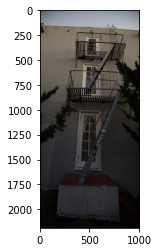

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


array([[[0.30588235, 0.3372549 , 0.38823529],
        [0.30588235, 0.3372549 , 0.38823529],
        [0.30588235, 0.3372549 , 0.38823529],
        ...,
        [0.36862745, 0.40392157, 0.43137255],
        [0.36470588, 0.4       , 0.43529412],
        [0.36470588, 0.4       , 0.43529412]],

       [[0.30588235, 0.32941176, 0.38431373],
        [0.30980392, 0.33333333, 0.38823529],
        [0.30980392, 0.33333333, 0.38823529],
        ...,
        [0.36862745, 0.40392157, 0.43921569],
        [0.36862745, 0.40392157, 0.43921569],
        [0.36862745, 0.40392157, 0.43921569]],

       [[0.30588235, 0.32941176, 0.38431373],
        [0.30980392, 0.33333333, 0.38823529],
        [0.31372549, 0.3372549 , 0.39215686],
        ...,
        [0.37647059, 0.41176471, 0.44705882],
        [0.37254902, 0.40784314, 0.44313725],
        [0.37254902, 0.40784314, 0.44313725]],

       ...,

       [[0.01176471, 0.01176471, 0.01176471],
        [0.01960784, 0.01176471, 0.01568627],
        [0.01960784, 0

In [416]:
file_name = 'out/ladder1_ladder2.json'
im1 = 'in/ladder1.jpeg'
im2 = 'in/ladder2.jpeg'

im1 = read(im1)
im2 = read(im2)

# read keypoints 
with open(file_name, 'r') as f:
    all_points = json.load(f)

key1 = all_points['first']
key2 = all_points['second']

blend_level = 5
final_img = morph_images_vertical(im1, im2, key1, key2, blend_level=blend_level)
plt.imshow(final_img)
plt.show()

(53, 9) (53,)
[ 2.11157433e+00 -1.99193188e-01 -3.49479827e+02  5.32615633e-01
  1.75842226e+00 -1.37479527e+02  2.90370599e-03 -1.00176190e-04
  1.00000000e+00]


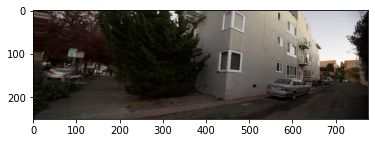

In [381]:
file_name = 'out/small_small2.json'
im1 = 'in/small.jpeg'
im2 = 'in/small2.jpeg'

im1 = read(im1)
im2 = read(im2)

# read keypoints 
with open(file_name, 'r') as f:
    all_points = json.load(f)

key1 = all_points['first']
key2 = all_points['second']

final_img = morph_images_horizontal(im1, im2, key1, key2, blend_level=2)
plt.imshow(final_img)
plt.show()

(53, 9) (53,)
[ 2.06987189e+00 -1.92296797e-01 -3.41274011e+02  5.19546892e-01
  1.73849413e+00 -1.35271722e+02  2.79016072e-03 -5.46575742e-05
  1.00000000e+00]


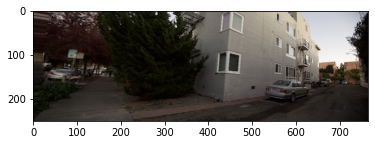

In [382]:
refined_key2 = refine_points(key1, key2)
final_img = morph_images_horizontal(im1, im2, key1, refined_key2, blend_level=2)
plt.imshow(final_img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


array([[[0.3372549 , 0.36862745, 0.38039216],
        [0.3372549 , 0.36862745, 0.38039216],
        [0.2745098 , 0.30196078, 0.3254902 ],
        ...,
        [0.23921569, 0.24705882, 0.29411765],
        [0.2627451 , 0.2627451 , 0.30980392],
        [0.27843137, 0.27058824, 0.31372549]],

       [[0.3372549 , 0.36862745, 0.38039216],
        [0.3372549 , 0.36862745, 0.38039216],
        [0.3372549 , 0.36862745, 0.38039216],
        ...,
        [0.25098039, 0.25882353, 0.30588235],
        [0.26666667, 0.26666667, 0.31372549],
        [0.27843137, 0.27843137, 0.31764706]],

       [[0.34901961, 0.36862745, 0.38431373],
        [0.34901961, 0.36862745, 0.38431373],
        [0.34901961, 0.36862745, 0.38431373],
        ...,
        [0.26666667, 0.2745098 , 0.32156863],
        [0.29803922, 0.30980392, 0.34509804],
        [0.32941176, 0.32941176, 0.36862745]],

       ...,

       [[0.23137255, 0.10980392, 0.09803922],
        [0.23137255, 0.10980392, 0.09803922],
        [0.23137255, 0

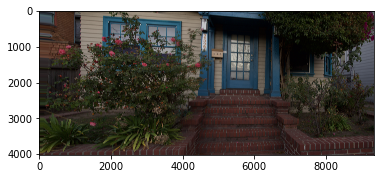

In [419]:
file_name = 'out/house2_house1.json'
im1 = 'in/house2.jpeg'
im2 = 'in/house1.jpeg'

im1 = read(im1)
im2 = read(im2)

# read keypoints 
with open(file_name, 'r') as f:
    all_points = json.load(f)

key1 = all_points['first']
key2 = all_points['second']
key2 = refine_points(key1, key2)
final_img = morph_images_horizontal(im1, im2, key1, key2, blend_level=5)
plt.imshow(final_img)
save(final_img, 'docs/images/house_pano.png')